# 利用各國股市收盤價預測台灣股市收盤價
我們知道各國的股市收盤時間是不一樣的，我們可以根據這一點使用已經收盤的股市來預測台灣股市最後的走向。

## 1. 查詢各國股市收盤時間

![stock time](stock_time.jpg)

根據圖中所提供的各地股市交易時間一覽表，台灣的最後的收盤時間是13:30，而收盤時間較台灣早的則有紐西蘭的13:00以及澳洲的14:00，這兩個地區可以直接使用當天的資料，而其他地方的股市我們取只能前一天的資料來當做預測模型的輸入。

## 2. 下載Yahoo Finace中下載各國的股市資料

![World Indices](world_indices.jpg)

參考連結：https://finance.yahoo.com/world-indices

## 3. 讀入股市資料並進行資料清理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

### 讀入股票代碼對應的地區資料並根據需要分組

In [2]:
# 將股票代碼對應的地區資料讀入
area = pd.read_csv('data/area.csv')
area.head()

,Code,Area
0,^AORD,Australia
1,^AXJO,Australia
2,^BFX,Belgium
3,^BSESN,India
4,^BUK100P,UnitedKingdom


In [14]:
# 將股市代號分為:
# 1. 收盤時間較台灣早的股市代號(earlier_stocks)
# 2. 收盤時間較台灣晚的股市代號(later_stocks), 
#    因為收盤時間較晚, 如果要使用這些股市來預測, 必須使用前一日的資料
earlier_taiwan_contries = ['Australia', 'NewZealand', 'Japan']  # 收盤早於台灣的國家
taiwan_stock = '^TWII'  # 台灣股市代號(TSEC weighted index)
earlier_stocks = list(
    area[area['Area'].isin(earlier_taiwan_contries)]['Code'])
later_stocks = list(
    area[~area['Area'].isin(earlier_taiwan_contries)]['Code'])
later_stocks.remove(taiwan_stock)

print(f'Taiwan: {taiwan_stock}')
print(f'Close Time Earlier than Taiwan: {earlier_stocks}')
print(f'Close Time Later than Taiwan: {later_stocks}')

Taiwan: ^TWII
Close Time Earlier than Taiwan: ['^AORD', '^AXJO', '^N225']
Close Time Later than Taiwan: ['^BFX', '^BSESN', '^BUK100P', '^BVSP', '^DJI', '^FCHI', '^GDAXI', '^GSPC', '^GSPTSE', '^HSI', '^JKSE', '^KS11', '^MXX', '^NYA', '^NZ50', '^RUT', '^STOXX50E', '^TA125.TA', '^XAX', '000001.SS', 'IMOEX.ME']


### 撰寫讀取股市資料的函式

In [16]:
def read_stock(code):
    """讀入對應代號的股票資料"""
    file_path = f'./data/{code}.csv'
    index = pd.read_csv(file_path)
    index = index[['Date', 'Close']]
    index['Date'] = pd.to_datetime(index['Date'])
    index.rename(columns={'Close': code}, inplace=True)
    return index

# 測試函式輸出
read_stock(taiwan_stock).head()

,Date,^TWII
0,2020-05-11,11013.259766
1,2020-05-12,10879.469727
2,2020-05-13,10938.269531
3,2020-05-14,10780.879883
4,2020-05-15,10814.919922


### 將所有股市資料讀入並合併

In [21]:
# 讀入台灣股市資料
stock = read_stock(taiwan_stock)

for code in (earlier_stocks + later_stocks):
    single_stock = read_stock(code)
    if code in later_stocks:
        # 對於收盤時間較台灣晚的股市，必須使用前一天的資料來預測
        single_stock['Date'] = single_stock['Date'] - dt.timedelta(days=1)
    stock = pd.merge(stock, single_stock, on='Date')
    
# 去除有空值的紀錄
stock.dropna(inplace=True)
# 將收盤價的欄位轉為數值
stock.iloc[:, 1:] = stock.iloc[:, 1:].apply(pd.to_numeric)
stock.head()

,Date,^TWII,^AORD,^AXJO,^N225,^BFX,^BSESN,^BUK100P,^BVSP,^DJI,...,^KS11,^MXX,^NYA,^NZ50,^RUT,^STOXX50E,^TA125.TA,^XAX,000001.SS,IMOEX.ME
0,2020-05-11,11013.259766,5559.100098,5461.200195,20390.660156,3067.800049,31371.119141,598.880005,77872.0,23764.779297,...,1922.170044,37462.890625,11055.580078,10818.669922,1275.540039,2884.199951,1418.250000,1863.550049,2891.555908,2642.040039
1,2020-05-12,10879.469727,5497.299805,5403.000000,20366.480469,2973.770020,32008.609375,588.429993,77772.0,23247.970703,...,1940.420044,36394.589844,10829.440430,10788.030273,1233.250000,2810.550049,1395.969971,1791.650024,2898.050049,2604.979980
2,2020-05-13,10938.269531,5513.700195,5421.899902,20267.050781,2899.510010,31122.890625,572.020020,79011.0,23625.339844,...,1924.959961,36094.140625,10927.410156,10745.160156,1237.550049,2760.229980,1331.239990,1809.670044,2870.342041,2590.310059
3,2020-05-18,10740.549805,5557.500000,5460.500000,20133.730469,2960.889893,30196.169922,599.000000,80742.0,24206.859375,...,1980.609985,35862.039063,11248.969727,10790.139648,1307.719971,2902.580078,1406.459961,1884.520020,2898.575928,2711.719971
4,2020-05-19,10860.440430,5658.799805,5559.500000,20433.449219,2994.699951,30818.609375,605.640015,81319.0,24575.900391,...,1989.640015,36026.980469,11420.040039,10788.059570,1346.930054,2942.389893,1414.290039,1941.599976,2883.738037,2770.790039


### 查看整理後的股市概況

C:\Users\TWP\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


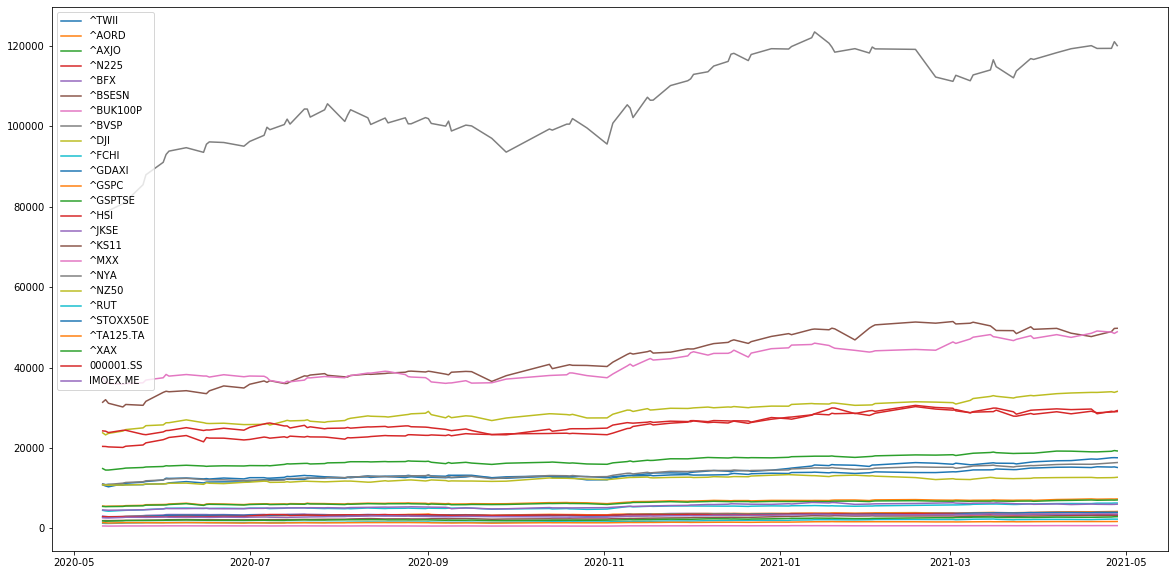

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(stock['Date'], stock[taiwan_stock], label=taiwan_stock)
for code in (earlier_stocks+later_stocks):
    plt.plot(stock['Date'], stock[code], label=code)
plt.legend()

In [23]:
# 開始與結束時間
min(stock["Date"]).date(), max(stock["Date"]).date()

(datetime.date(2020, 5, 11), datetime.date(2021, 4, 28))

In [30]:
print(stock.iloc[:, 1:])

            ^TWII        ^AORD        ^AXJO         ^N225         ^BFX  \
0    11013.259766  5559.100098  5461.200195  20390.660156  3067.800049   
1    10879.469727  5497.299805  5403.000000  20366.480469  2973.770020   
2    10938.269531  5513.700195  5421.899902  20267.050781  2899.510010   
3    10740.549805  5557.500000  5460.500000  20133.730469  2960.889893   
4    10860.440430  5658.799805  5559.500000  20433.449219  2994.699951   
5    10871.179688  5729.899902  5615.600098  20741.650391  3165.459961   
6    10997.209961  5889.899902  5780.000000  21271.169922  3234.070068   
7    11079.019531  5938.399902  5819.200195  22062.390625  3320.419922   
8    11127.929688  5960.100098  5835.100098  22325.609375  3427.239990   
9    11320.160156  6064.899902  5941.600098  22613.759766  3449.889893   
10   11637.110352  6262.899902  6144.899902  23091.029297  3442.659912   
11   11306.259766  5830.000000  5719.799805  21530.949219  3447.649902   
12   11511.639648  6058.100098  5942.2

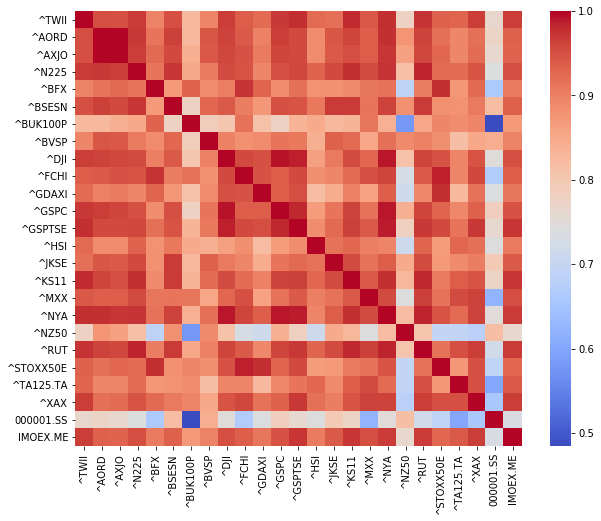

In [61]:
# 股市之間的關聯度熱圖
import seaborn as sns
corr = stock.iloc[:, 1:].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## 4. 利用清理後的資料訓練模型

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

### 分為訓練資料與測試資料

In [34]:
train, test = train_test_split(stock, random_state=10, train_size=0.8)
x_cols = earlier_stocks + later_stocks
train_x = train[x_cols]
train_y = train[taiwan_stock]

In [39]:
train_x.head()

,^AORD,^AXJO,^N225,^BFX,^BSESN,^BUK100P,^BVSP,^DJI,^FCHI,^GDAXI,...,^KS11,^MXX,^NYA,^NZ50,^RUT,^STOXX50E,^TA125.TA,^XAX,000001.SS,IMOEX.ME
96,7036.399902,6799.500000,29384.519531,3927.149902,50136.578125,676.289978,116850.0,33066.960938,6088.040039,15008.610352,...,3070.000000,47905.000000,15626.110352,12446.759766,2195.800049,3926.199951,1656.920044,2721.949951,3456.679932,3525.229980
68,6900.299805,6660.200195,26732.439453,3701.709961,46263.171875,649.320007,116146.0,30199.310547,5530.310059,13362.870117,...,2756.820068,43543.351563,14402.320313,12767.169922,1959.760010,3521.500000,1537.640015,2372.030029,3367.229980,3248.110107
38,6245.899902,6060.500000,23139.759766,3314.229980,38900.800781,582.710022,102168.0,28645.660156,4938.100098,12974.250000,...,2349.550049,37487.988281,13113.740234,11793.160156,1578.579956,3277.580078,1416.890015,2122.879883,3410.606934,2975.000000
52,6403.100098,6191.799805,23639.460938,3202.189941,40558.488281,575.179993,101918.0,28363.660156,4851.379883,12543.059570,...,2355.050049,38652.191406,13145.919922,12407.290039,1630.250000,3171.409912,1395.489990,2035.079956,3312.500000,2803.169922
74,6953.700195,6684.200195,27258.380859,3647.209961,48437.781250,656.880005,119223.0,30391.599609,5564.600098,13651.219727,...,2990.570068,44908.121094,14536.530273,13367.650391,1979.109985,3547.850098,1556.430054,2462.979980,3528.677002,3359.149902


### 訓練決策樹回歸模型

In [40]:
train_y.head()

96    16475.970703
68    14211.049805
38    12591.450195
52    12877.250000
74    14902.030273
Name: ^TWII, dtype: float64

In [41]:
clf = DecisionTreeRegressor()
clf.fit(train_x, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [42]:
clf.get_depth(), clf.get_n_leaves()

(10, 84)

### 驗證預測結果

In [49]:
# 因為前面使用train_test_split函式會將日期順序打亂, 這裡重新排序以便繪圖
test.sort_values('Date', inplace=True)
test_x = test[x_cols]
test_y = test[taiwan_stock]
predict_y = clf.predict(test_x)

C:\Users\TWP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
test_x.head()

,^AORD,^AXJO,^N225,^BFX,^BSESN,^BUK100P,^BVSP,^DJI,^FCHI,^GDAXI,...,^KS11,^MXX,^NYA,^NZ50,^RUT,^STOXX50E,^TA125.TA,^XAX,000001.SS,IMOEX.ME
1,5497.299805,5403.000000,20366.480469,2973.770020,32008.609375,588.429993,77772.0,23247.970703,4344.950195,10542.660156,...,1940.420044,36394.589844,10829.440430,10788.030273,1233.250000,2810.550049,1395.969971,1791.650024,2898.050049,2604.979980
2,5513.700195,5421.899902,20267.050781,2899.510010,31122.890625,572.020020,79011.0,23625.339844,4273.129883,10337.019531,...,1924.959961,36094.140625,10927.410156,10745.160156,1237.550049,2760.229980,1331.239990,1809.670044,2870.342041,2590.310059
3,5557.500000,5460.500000,20133.730469,2960.889893,30196.169922,599.000000,80742.0,24206.859375,4458.160156,11075.290039,...,1980.609985,35862.039063,11248.969727,10790.139648,1307.719971,2902.580078,1406.459961,1884.520020,2898.575928,2711.719971
14,6058.000000,5944.500000,22437.269531,3433.879883,35430.429688,631.299988,95975.0,26156.099609,5017.680176,12523.759766,...,2131.239990,38217.679688,12077.740234,11132.580078,1439.339966,3298.830078,1377.979980,1993.469971,2970.620117,2791.969971
19,6034.299805,5920.299805,22438.650391,3393.610107,36737.691406,602.739990,99160.0,25706.089844,4921.009766,12489.459961,...,2167.899902,36795.949219,11928.629883,11440.879883,1398.920044,3261.169922,1340.939941,1970.780029,3450.593994,2782.429932


In [51]:
test_y.head()

1     10879.469727
2     10938.269531
3     10740.549805
14    11572.929688
19    12170.190430
Name: ^TWII, dtype: float64

In [54]:
predict_y

array([10860.44043 , 10860.44043 , 10860.44043 , 11703.419922,
       12092.969727, 12703.280273, 12862.370117, 12583.879883,
       12787.820313, 12703.280273, 12787.820313, 12583.879883,
       12908.339844, 13081.719727, 13551.830078, 14177.459961,
       15612.      , 15612.      , 14304.459961, 15500.700195,
       16475.970703])

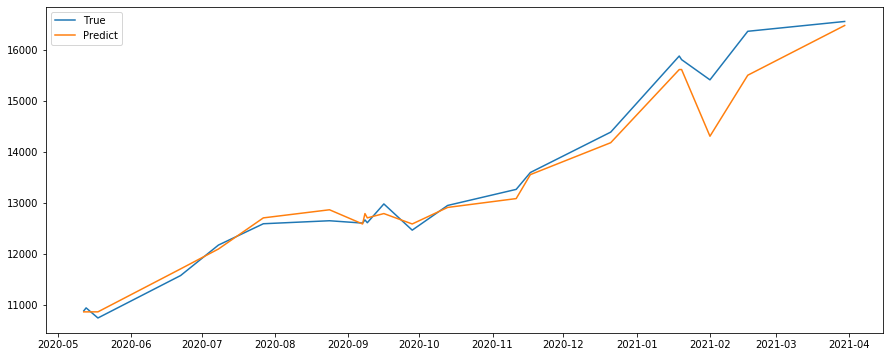

In [55]:
# 預測結果於實際情況差異
plt.figure(figsize=(15, 6))
plt.plot(test['Date'], test_y, label='True')
plt.plot(test['Date'], predict_y, label='Predict')
plt.legend()

In [59]:
# 預測結果與實際情況的平均差
def get_mean_square_error(y1s, y2s):
    return sum((y1-y2)**2 for y1, y2 in zip(y1s, y2s)) / len(y1s)
mse = get_mean_square_error(test_y, predict_y)
mse**0.5

333.549073879598

## 5. 選擇高相關的股市資料重新訓練

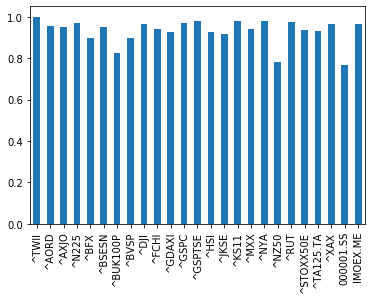

In [62]:
# 查看相關度的分布狀況
corr = abs(corr[taiwan_stock])
corr.plot.bar()

['^TWII', '^AORD', '^AXJO', '^N225', '^BSESN', '^DJI', '^GSPC', '^GSPTSE', '^KS11', '^NYA', '^RUT', '^XAX', 'IMOEX.ME']


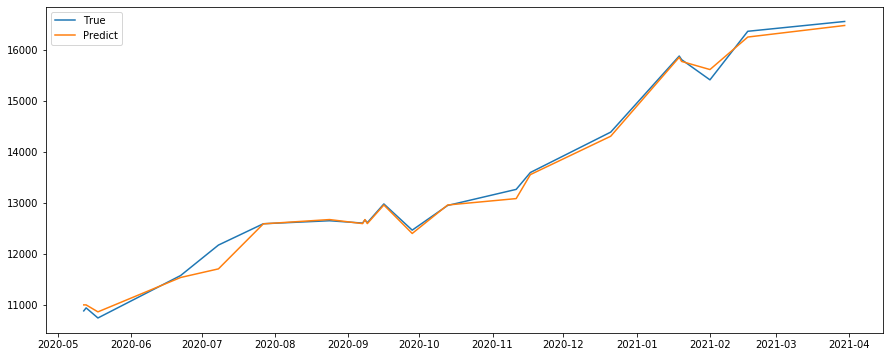

In [78]:
threshold = 0.95
x_cols = list(corr[corr>threshold].index)
print(x_cols)
train_x = train[x_cols]
train_y = train[taiwan_stock]
clf = DecisionTreeRegressor()
clf.fit(train_x, train_y)
test_x = test[x_cols]
test_y = test[taiwan_stock]
predict_y = clf.predict(test_x)

plt.figure(figsize=(15, 6))
plt.plot(test['Date'], test_y, label='True')
plt.plot(test['Date'], predict_y, label='Predict')
plt.legend()

In [79]:
mse = get_mean_square_error(test_y, predict_y)
mse**0.5

130.76884598075884

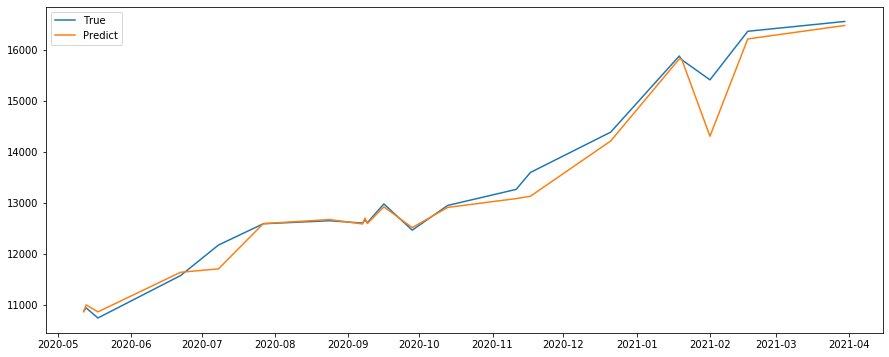

In [74]:
threshold = 0.8
x_cols = list(corr[corr>threshold].index)
train_x = train[x_cols]
train_y = train[taiwan_stock]
clf = DecisionTreeRegressor()
clf.fit(train_x, train_y)
test_x = test[x_cols]
test_y = test[taiwan_stock]
predict_y = clf.predict(test_x)

plt.figure(figsize=(15, 6))
plt.plot(test['Date'], test_y, label='True')
plt.plot(test['Date'], predict_y, label='Predict')
plt.legend()

In [75]:
mse = get_mean_square_error(test_y, predict_y)
mse**0.5

291.47140983398504